### Reading raw data 

In [1]:
from pandas import read_parquet, read_csv, DataFrame
from pathlib import Path

url: str = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2019-12.parquet"
df: DataFrame = read_parquet(path=url)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1.0,N,142,116,2,14.50,3.00,0.5,0.0,0.00,0.3,18.30,2.5,None
1,1,2019-12-01 00:12:08,2019-12-01 00:12:14,1.0,0.00,1.0,N,145,145,2,2.50,0.50,0.5,0.0,0.00,0.3,3.80,0.0,None
2,1,2019-12-01 00:25:53,2019-12-01 00:26:04,1.0,0.00,1.0,N,145,145,2,2.50,0.50,0.5,0.0,0.00,0.3,3.80,0.0,None
3,1,2019-12-01 00:12:03,2019-12-01 00:33:19,2.0,9.40,1.0,N,138,25,1,28.50,0.50,0.5,10.0,0.00,0.3,39.80,0.0,None
4,1,2019-12-01 00:05:27,2019-12-01 00:16:32,2.0,1.60,1.0,N,161,237,2,9.00,3.00,0.5,0.0,0.00,0.3,12.80,2.5,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896312,2,2019-12-31 23:56:29,2020-01-01 00:11:17,NaN,2.82,NaN,None,143,141,0,18.95,2.75,0.0,0.0,0.00,0.3,22.00,NaN,None
6896313,2,2019-12-31 23:11:53,2019-12-31 23:30:56,NaN,3.75,NaN,None,148,246,0,22.45,2.75,0.0,0.0,0.00,0.3,25.50,NaN,None
6896314,2,2019-12-31 23:57:21,2020-01-01 00:23:34,NaN,6.46,NaN,None,197,205,0,34.86,2.75,0.0,0.0,0.00,0.3,37.91,NaN,None
6896315,2,2019-12-31 23:37:29,2020-01-01 00:28:21,NaN,5.66,NaN,None,90,74,0,36.45,2.75,0.0,0.0,0.00,0.3,39.50,NaN,None


In [2]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

## Business use case analysis 

Business use case requires building an ML solution that users could interact with to obtain trip price estimates. In order to achieve that, the following assumptions were introduced:

### Assumption 1

If time of the day, distance and duration are fixed while trip start and finish zones vary - no matter the combination, price remains the same (NEED TO CHECK IF THIS TRUE IN NYC).

### Assumption 2

__Users interact with web app real time__

We must only use information that is available at prediction time which takes places __before__ the trip.

The following list of available columns within the dataset:

- _VendorID_ - `A code indicating the TPEP provider that provided the record.` Given this description in metadata it's safe to assume that neither user, nor TLC can provide such information to the model
- _tpep_pickup_datetime_ - `The date and time when the meter was engaged.` We can't know that exactly, but a modified version of it, like `hour_of_the_day`, `day_of_the_week`, `is_weekend`, `is_weekday` can be extracted by asking user to select day of week he/she expects to take a taxi and roughly at what hour (e.g. morning, during the day, evening, night, etc). All of the features listed above can be then extracted easily and used at inference
- _tpep_dropoff_datetime_ - `The date and time when the meter was disengaged.` We can't know it before the trip as well as at inference time. There should be a separate ML model that estimates trip duration and then the final model that predicts the trip price should input that since trip price definetely depends on trip duration as mentioned [here](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page)
- _Passenger_count_ - `The number of passengers in the vehicle. This is a driver-entered value.` According to the https://www.nyc.gov/site/tlc/passengers/taxi-fare.page `There is no charge for extra passengers, luggage or bags, or paying by credit card.` hence we can ignore this column
- _Trip_distance_ - `The elapsed trip distance in miles reported by the taximeter.` We can't know that at prediction time. Having said that, we can have a separate service that calculates the expected distance between two locations. This can be as simple as [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula) or even something more advanced and accurate like expected driveable distance calculated by distance matrix APIs provided by navigation systems or Big Tech Companies like Google (https://developers.google.com/maps/documentation/distance-matrix/overview), Microsoft (https://www.microsoft.com/en-us/maps/distance-matrix), etc. Microsoft is free for the [first 150k requests](https://www.microsoft.com/en-us/maps/create-a-bing-maps-key) and this dataset contains only 30k+ unique pickup / dropoff location pairs so we wouldn't have to spend a dime.
- _PULocationID_ - `TLC Taxi Zone in which the taximeter was engaged.` User can provide this as an input to the app.
- _DOLocationID_ - `TLC Taxi Zone in which the taximeter was disengaged.` Same as with `PULocationID`, user can provide it.
- _RateCodeID_ - `The final rate code in effect at the end of the trip. 1= Standard rate; 2=JFK; 3=Newark; 4=Nassau or Westchester; 5=Negotiated fare; 6=Group ride;` ???????? 
- _Store_and_fwd_flag_ - `This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip; N= not a store and forward trip;` Given this defintion, it's just irrelevant to us.
- _Payment_type_ - `A numeric code signifying how the passenger paid for the trip. 1= Credit card; 2= Cash; 3= No charge; 4= Dispute; 5= Unknown; 6= Voided trip;`. According the https://www.nyc.gov/site/tlc/passengers/taxi-fare.page `There is no charge for extra passengers, luggage or bags, or paying by credit card.` Plus we can't know how things will play out (e.g. whether there gonna be a dispute) before the trip, hence we can't use it in modelling.
- _Fare_amount_ - `The time-and-distance fare calculated by the meter.` This should be the target we train the model on in case we split the problem into predicting base fare price and resolving applicables taxes for the trip separately (ML estimates price, a separate service retrieves applicable taxes and fees).
- _Total_amount_ - `The total amount charged to passengers. Does not include cash tips.` _Total_amount_ - _Tip_amount_ is going to be the target for the first baseline model that predicts price after taxes minus tips. A more advanced approach of splitting into base price estimation + resolving taxes introduces additional complexity and first, a baseline model needs to be built in order to keep track and measure each return on investment of each iteration listed out below.
- _Tip_amount_ - `Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.`. This should be subtracted from the `total_amount` in the baseline model

Ideally, this problem should be split into 2 components:
1. Coming up with a service that resolves and fetches applicable taxes / charges for the trip. Most of the taxes can be resolved with simple if-else statements as seen [here](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page). Though there are a couple of exceptions: 
- `congestion_surcharge` is a bit problematic, even though we know exactly if-else rules when this charge is applied, still we can't know if it going to be applied at the end of the trip due to its nature. According https://www.nyc.gov/site/tlc/passengers/taxi-fare.page fee is only applies if trip begins, ends or passes through Manhattan south of 96th Street.
- `tolls_amount` is also tricky since can't know at inference time what route the taxi driver will take. We can only get a better understanding once we start taking into account expected driveable distance and expected route of the driver. Same Google and Microsoft distance matrix APIs could help us a lot with that.
2. Predicting base trip price before taxes + congestion_surcharge + tolls_amount with machine learning. We can't use if-else statement to figure out exactly what base price and two of the fees are going to be. We can only predict this given historical data we have at our disposal.

Finally results of part 1 and 2 should be added together and its output is our expected trip price after taxes which should be more accurate than just blindly trying to predict price after taxes.

These are charges that we can infer easily at prediction time with if-else statements:
- Extra - `Miscellaneous extras and surcharges. Currently, this only includes the \\$0.50 and \\$1 rush hour and overnight charges.`
- MTA_tax - `\\$0.50 MTA tax that is automatically triggered based on the metered rate in use.`. There is a location metadata file available at `./data/taxi_zone_lookup.csv` that can tells up if dropoff location is eligible for MTA_tax
- Improvement_surcharge - `\\$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.`
- Airport_fee - `$1.25 for pick up only at LaGuardia and John F. Kennedy Airports`

### Potential baseline model ideas and further iterations to improve it

At the very top are ideas that require least effort, but their expected quality of the predictions should in turn be least accurate. Each addition of more complexity to the system / solution should only come once there is an established baseline model that could be used a reference point in order to measure progress and improvements on price estimatates. Furthermore, it setups the whole project in a way that makes it easier to evaluate return on investment with each progression. At some point, costs of improving model a little bit can outweight gains. Having a strong baseline and trying to improve on top in this manner helps to catch these moments and rather focus on something that bring more value. With that being said, in this project I'll focus on building a baseline model. Below are seen other ideas / hypotheses that might be worth looking into in order to improve accuracy of the price estimates:

1. Build a very basic baseline trip price estimation model from pickup and dropoff location_ids, time while predicting _Total_amount_ - _Tip_amount_ which is price after taxes without tips (to avoid that hassle of dealing with taxes mentioned above). 
2. Extend the baseline model where instead of pickup / dropoff location_ids, metadata from `./data/taxi_zone_lookup.csv` is joined and used instead to represent locations (e.g. instead of `PULocationID`, `borough`, `zone` and `service_zone` are used). Metadata is less granular and contains more data points per category which should lead to more stable predictions and less overfitting in general (also more interaction that model might pickup in training).
3. Improve model from above by separating taxes from trip price estimation since simple if-else statements are enough to know most of the applicable taxes / charges (with exception of `congestion_surcharge` and `total_tolls`, these need to be modeled together with base trip price estimatation). The price prediction problem is then split into two: building a model to predict `fare_amount + congestion_surcharge + total_tolls` and building separate service for retrieving applicable fees that would be added on top of previous predictions. Only things that we don't know how to write a program for (e.g. if-else conditions) should be modeled with ML otherwise it needs to solved by writing traditional software. First part only requires ML, the rest - not.
4. At this point we can start adding more complex features to `Fare_amount + congestion_surcharge + total_tolls` predictions as everything else doesn't not even rely on ML. Features like expected driveable distance between two zones (no need for ML, e.g. Microsoft Bing Maps distance matrix API should suffice it `https://www.microsoft.com/en-us/maps/distance-matrix` which is free for the first 150k requests) and estimated_trip_duration should greatly improve base trip price accuracy. It's strongly hinted in https://www.nyc.gov/site/tlc/passengers/taxi-fare.page (under _Standard Metered Fare_) that these two signals are what basically drives base fare prices ("Plus 50 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped."). A distance calculated by the [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) can complement already proposed feature set.
5. We could then instead ask users on the web app to enter exact pickup / dropoff address and we could map both address to exact coordinates improve accuracy of expected driveable distance and trip duration estimates and in turn - base price predictions.


Food for thought:
- Historical average trip count for the hour of the trip. For instance if user plans to take a taxi at 12 am, knowing average amount of trips at this hour would indicate demand for taxis. Higher demands results in higher fees.
- At some point introducing quantile regression to estimate not only price and but also it's confidence intervals. Narrow intervals would indicate that model is confident in making its prediction (might be due to many examples available in training data) and wide the opposite - model is not confident and lack of training examples for such trips might be a reason behind it
- Even though gdbt frameworks deal with it really well with categorical data like location_ids (and its associated metadata), utilizing target encoding technique might be a better alternative that can also applied at inference time. Due to time constrains, I will not look into this. Rushed application can lead to target leaking and overfitting. More info -> https://www.google.com/search?client=firefox-b-lm&q=target+encoding


### Exploration

#### Taxes

Sanity-checking if adding all taxes to `fare_amount` results in `total_amount`

In [3]:
all_tax_cols = df.iloc[:, 10:16].columns.tolist() + df.iloc[:, 17:].columns.tolist()
all_tax_cols

['fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'congestion_surcharge',
 'airport_fee']

In [4]:
expected_total = df[all_tax_cols].sum(axis=1).round(2)
actual_total = df["total_amount"].round(2)

In [5]:
(expected_total == actual_total).sum() / df.shape[0] 

0.6921363968622672

Nope. According to https://www.nyc.gov/site/tlc/passengers/taxi-fare.page, only for some trips `congestion_surcharge` is applied. "Plus New York State Congestion Surcharge of \$2.50 (Yellow Taxi) or \$2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street."

In [6]:
no_cong_tax_cols = all_tax_cols.copy()
no_cong_tax_cols.remove("congestion_surcharge")
no_cong_tax_cols

['fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'airport_fee']

In [7]:
expected_total_2 = df[no_cong_tax_cols].sum(axis=1).round(2)

In [8]:
(expected_total_2 == actual_total).sum() / df.shape[0] 

0.3893064950465589

Need more time to figure out how to reconstruct `total_amount` from `fare_amount` and taxes. This is not a blocker for this small project though since we're focus on predicting prices after taxes.

Analyzing the volume of null values

In [9]:
for col in df:
    print(col, 100*df[col].isnull().sum() / df.shape[0])

VendorID 0.0
tpep_pickup_datetime 0.0
tpep_dropoff_datetime 0.0
passenger_count 0.7397861786225894
trip_distance 0.0
RatecodeID 0.7397861786225894
store_and_fwd_flag 0.7397861786225894
PULocationID 0.0
DOLocationID 0.0
payment_type 0.0
fare_amount 0.0
extra 0.0
mta_tax 0.0
tip_amount 0.0
tolls_amount 0.0
improvement_surcharge 0.0
total_amount 0.0
congestion_surcharge 0.7397861786225894
airport_fee 100.0


The whole `airport_fee` column are nulls, thus we can drop it

In [11]:
df.drop(columns=["airport_fee"], inplace=True)

Amount of records with nulls values is negligible, we can drop them with little downside in this project. Even if this wasn't the case, most popular gradient boosted decision tree frameworks deal with missing data. For more info:
- https://xgboost.readthedocs.io/en/stable/faq.html#how-to-deal-with-missing-values
- https://catboost.ai/en/docs/concepts/algorithm-missing-values-processing
- https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle

__N.B.__ In real world scenarios it makes sense to reach out to data producers and ask them if those whether those nulls should even exist and if that's the case, what do they mean, how to deal with them. Quite often missing values is a sign of an underlying bug and this should be brought to data producers attention so that they could fix it.

In [13]:
# Dropping records with at least 1 missing value
df.dropna(inplace=True)

#### Preprocessing the target

In [15]:
df.loc[:, "target"] = df.loc[:, "total_amount"] - df.loc[:, "tip_amount"]

Text(0.5, 1.0, 'Total amount - tips distribution')

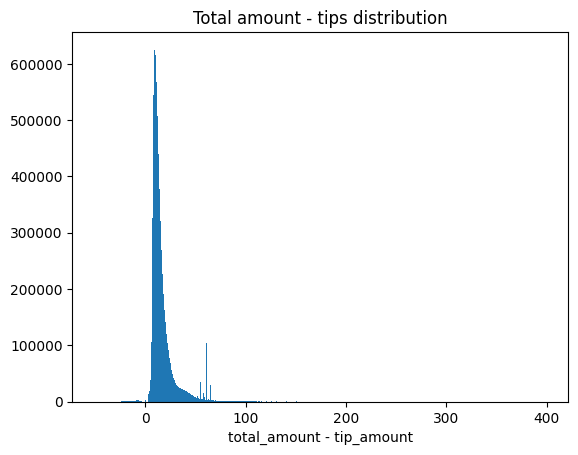

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.hist(df["target"], 
         bins=np.arange(-50, 400))
plt.xlabel("total_amount - tip_amount")
plt.title("Total amount - tips distribution")

Spreading out highly concentrated results with log scale

Text(0.5, 1.0, 'Total amount - tips distribution')

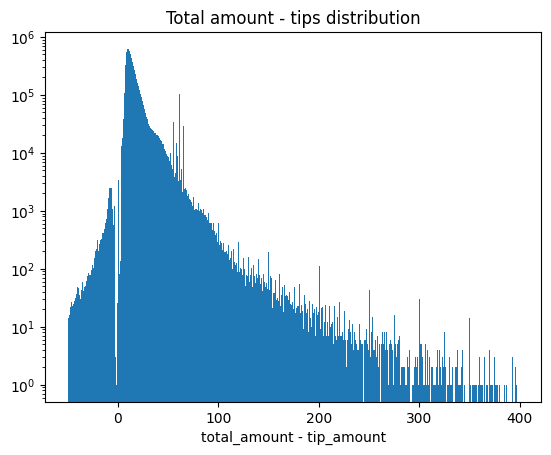

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.hist(df["target"], 
         bins=np.arange(-50, 400),
         log=True)
plt.xlabel("total_amount - tip_amount")
plt.title("Total amount - tips distribution")

In [18]:
print(df["target"].min())
print(df["target"].max())

-1472.8
398471.2


There are suspiciously high and low prices. It's doubtful that somebody paid 400k for a ride with taxi as well as it's doubtful that driver paid for the trip himself :)

All outliers should be clipped.

In [19]:
# Clipping unnecassary records
df = df[(df["target"] > 0)&(df["target"] < 1000)]
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,target
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1.0,N,142,116,2,14.5,3.0,0.5,0.00,0.0,0.3,18.30,2.5,18.3
1,1,2019-12-01 00:12:08,2019-12-01 00:12:14,1.0,0.00,1.0,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,0.0,3.8
2,1,2019-12-01 00:25:53,2019-12-01 00:26:04,1.0,0.00,1.0,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,0.0,3.8
3,1,2019-12-01 00:12:03,2019-12-01 00:33:19,2.0,9.40,1.0,N,138,25,1,28.5,0.5,0.5,10.00,0.0,0.3,39.80,0.0,29.8
4,1,2019-12-01 00:05:27,2019-12-01 00:16:32,2.0,1.60,1.0,N,161,237,2,9.0,3.0,0.5,0.00,0.0,0.3,12.80,2.5,12.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6845294,2,2019-12-31 23:09:42,2019-12-31 23:22:39,1.0,1.47,1.0,N,68,246,2,10.0,0.5,0.5,0.00,0.0,0.3,13.80,2.5,13.8
6845295,2,2019-12-31 23:46:57,2019-12-31 23:50:54,1.0,0.97,1.0,N,233,170,1,5.0,0.5,0.5,1.76,0.0,0.3,10.56,2.5,8.8
6845296,2,2019-12-31 23:22:03,2019-12-31 23:29:06,1.0,3.30,1.0,N,262,224,1,11.0,0.5,0.5,2.96,0.0,0.3,17.76,2.5,14.8
6845297,2,2019-12-31 23:33:47,2019-12-31 23:40:10,1.0,1.55,1.0,N,137,4,2,7.0,0.5,0.5,0.00,0.0,0.3,10.80,2.5,10.8


### Feature engineering

In [20]:
location_meta_df = read_csv("~/Desktop/yellow-taxi-trip/data/taxi_zone_lookup.csv")
location_meta_df

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [21]:
full_df = (df
          .merge(location_meta_df.add_prefix("PU"), on="PULocationID")
          .merge(location_meta_df.add_prefix("DO"), on="DOLocationID"))
full_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,target,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1.0,N,142,116,2,...,0.3,18.30,2.5,18.30,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
1,2,2019-12-01 00:03:51,2019-12-01 00:14:46,5.0,3.56,1.0,N,142,116,2,...,0.3,16.30,2.5,16.30,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
2,2,2019-12-01 00:38:18,2019-12-01 00:54:47,1.0,4.48,1.0,N,142,116,1,...,0.3,23.16,2.5,19.30,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
3,2,2019-12-01 01:23:23,2019-12-01 01:36:31,1.0,5.35,1.0,N,142,116,1,...,0.3,22.80,2.5,20.80,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
4,2,2019-12-01 02:15:49,2019-12-01 02:32:47,1.0,4.02,1.0,N,142,116,2,...,0.3,17.80,2.5,17.80,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6822683,2,2019-12-30 05:47:11,2019-12-30 06:17:47,1.0,12.15,1.0,N,132,2,2,...,0.3,41.88,0.0,41.88,Queens,JFK Airport,Airports,Queens,Jamaica Bay,Boro Zone
6822684,1,2019-12-22 17:25:46,2019-12-22 18:43:49,1.0,0.00,1.0,N,68,2,1,...,0.3,65.58,0.0,65.58,Manhattan,East Chelsea,Yellow Zone,Queens,Jamaica Bay,Boro Zone
6822685,1,2019-12-18 20:50:12,2019-12-18 21:48:38,1.0,0.00,1.0,N,250,2,1,...,0.3,60.70,0.0,60.70,Bronx,Westchester Village/Unionport,Boro Zone,Queens,Jamaica Bay,Boro Zone
6822686,2,2019-12-11 23:28:07,2019-12-11 23:45:31,1.0,13.36,5.0,N,196,2,1,...,0.3,72.36,0.0,60.30,Queens,Rego Park,Boro Zone,Queens,Jamaica Bay,Boro Zone


Ensuring that newly joined metadata doesn't introduce `nulls` since users can specify null value neither as a pickup, nor dropoff location

In [22]:
full_df.dropna(inplace=True)

Estimating how many requests to distance matrix API provider we would need in order to fetch all driveable distance estimates

In [22]:
full_df[["PULocationID", "DOLocationID"]].drop_duplicates().shape

(28059, 2)

In [25]:
full_df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'target',
 'PUBorough',
 'PUZone',
 'PUservice_zone',
 'DOBorough',
 'DOZone',
 'DOservice_zone']

Preparing time features

In [ ]:
df.head(30)

### Building trip distance estimator 

### Building trip duration estimator 

### Building trip price estimator 